# CNN intro

X_train.shape=(50000, 32, 32, 3), X_test.shape=(10000, 32, 32, 3)
y_train.shape=(50000,), y_test.shape=(10000,)


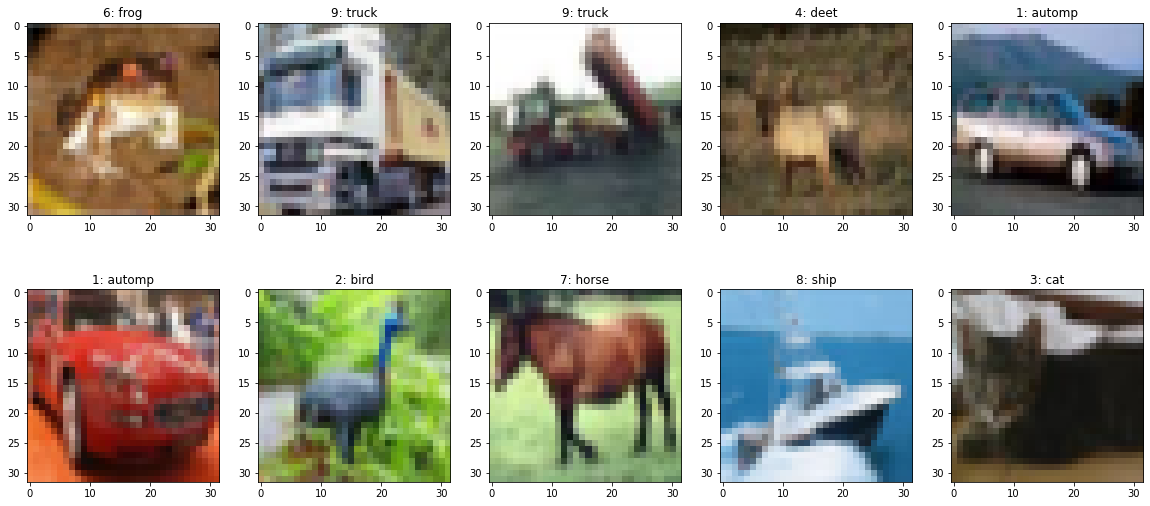

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.datasets.cifar10 import load_data

(X_train, y_train), (X_test, y_test) = load_data()
print(f"{X_train.shape=}, {X_test.shape=}")
y_train = y_train.ravel()
y_test = y_test.ravel()
print(f"{y_train.shape=}, {y_test.shape=}")

labels = ["airplane",
"automp",
"bird",
"cat",
"deet",
"dog",
"frog",
"horse",
"ship",
"truck"]

fig, axes = plt.subplots(2,5, figsize = (20,9))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i])
    ax.set_title(f"{y_train[i]}: {labels[y_train[i]]}")

In [10]:
scaled_X_train = X_train.astype("float32")/255
scaled_X_test = X_test.astype("float32")/255

___
## CNN Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate = .001, drop_rate = .5, kernels = [32, 64]):
    adam = Adam(learning_rate = learning_rate)

    model = Sequential(name = "CNN_model")

    ## The Convolutional layers
    for number_kernel in kernels:
        conv_layer = Conv2D(number_kernel, kernel_size = (3,3), 
                            activation = "relu", kernel_initializer = "he_normal", 
                            input_shape = X_train.shape[1:])
        
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

    # MLP layers
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation = "relu", kernel_initializer = "he_normal"))
    model.add(Dense(10, activation = "softmax"))

    model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["acc"])

    return model

model = CNN_model()
model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2304)              0 

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=5)

model.fit(
    scaled_X_train,
    y_train,
    epochs=100,
    callbacks = [early_stopper],
    validation_split=1/5)

Epoch 1/100
1250/1250 [==============================] - 50s 40ms/step - loss: 1.5651 - acc: 0.4319 - val_loss: 1.2069 - val_acc: 0.5724
Epoch 2/100
1250/1250 [==============================] - 49s 39ms/step - loss: 1.2130 - acc: 0.5670 - val_loss: 1.0364 - val_acc: 0.6404
Epoch 3/100
1250/1250 [==============================] - 49s 39ms/step - loss: 1.0653 - acc: 0.6255 - val_loss: 0.9834 - val_acc: 0.6566
Epoch 4/100
1250/1250 [==============================] - 49s 39ms/step - loss: 0.9595 - acc: 0.6626 - val_loss: 0.9325 - val_acc: 0.6821
Epoch 5/100
1250/1250 [==============================] - 49s 39ms/step - loss: 0.8784 - acc: 0.6909 - val_loss: 0.8776 - val_acc: 0.6965
Epoch 6/100
1250/1250 [==============================] - 49s 39ms/step - loss: 0.8026 - acc: 0.7175 - val_loss: 0.8502 - val_acc: 0.7072
Epoch 7/100
1250/1250 [==============================] - 51s 41ms/step - loss: 0.7457 - acc: 0.7370 - val_loss: 0.8425 - val_acc: 0.7109
Epoch 8/100
1250/1250 [==================

In [21]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2,figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax=ax[0], grid=True)
    metrics[["acc", "val_acc"]].plot(ax=ax[1], grid = True)

In [22]:
metrics = pd.DataFrame(model.history.history)

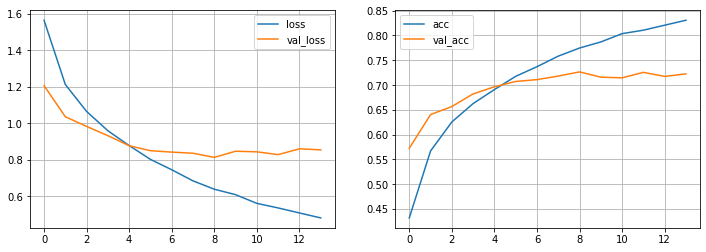

In [23]:
plot_metrics(metrics)

___
## Hyperparameter tuning

In [24]:
def evaluate_model(**kwargs):
    model = CNN_model(**kwargs)
    model.fit(
        scaled_X_train,
        y_train,
        validation_split = 1/5,
        epochs = 6
    )

    metrics = pd.DataFrame(model.history.history)
    val_acc = metrics["val_acc"].iloc[-1]
    return val_acc

In [25]:
dropout_acc = {}

for drop_rate in np.arange(.1,.6,.1):
    drop_rate = np.round(drop_rate,1)
    dropout_acc[drop_rate] = evaluate_model(drop_rate = drop_rate)

Epoch 1/6
1250/1250 [==============================] - 53s 42ms/step - loss: 1.4654 - acc: 0.4740 - val_loss: 1.2254 - val_acc: 0.5696
Epoch 2/6
1250/1250 [==============================] - 49s 39ms/step - loss: 1.0991 - acc: 0.6144 - val_loss: 1.0330 - val_acc: 0.6463
Epoch 3/6
1250/1250 [==============================] - 49s 39ms/step - loss: 0.9274 - acc: 0.6761 - val_loss: 0.9438 - val_acc: 0.6770
Epoch 4/6
1250/1250 [==============================] - 49s 39ms/step - loss: 0.7905 - acc: 0.7244 - val_loss: 0.9286 - val_acc: 0.6837
Epoch 5/6
1250/1250 [==============================] - 48s 39ms/step - loss: 0.6732 - acc: 0.7661 - val_loss: 0.9198 - val_acc: 0.6921
Epoch 6/6
1250/1250 [==============================] - 49s 39ms/step - loss: 0.5711 - acc: 0.7998 - val_loss: 0.9256 - val_acc: 0.6998
Epoch 1/6
1250/1250 [==============================] - 49s 39ms/step - loss: 1.4261 - acc: 0.4872 - val_loss: 1.1617 - val_acc: 0.5882
Epoch 2/6
1250/1250 [==============================] - 

<AxesSubplot:xlabel='Dropouts', ylabel='Validation acc'>

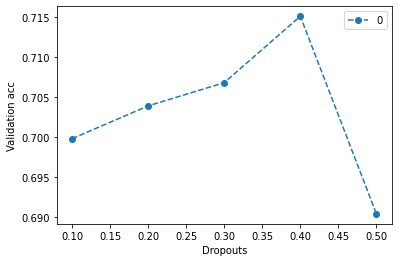

In [27]:
pd.DataFrame(dropout_acc.values(), index=dropout_acc.keys()).plot(xlabel="Dropouts", ylabel="Validation acc", style = "--o")